In [25]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
import glob
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [26]:
folders = sorted(glob.glob("../India_95/complete/*"))
images = []
for folder in folders:
    all_images = []
    for i in os.listdir(folder):
        path = os.path.join(folder,i)
        all_images.append(path)
    images.append([i for i in all_images if "forniceal_palpebral" in i][0])
print(f"Total Number of Images = {len(images)}")

Total Number of Images = 95


In [27]:
def mask(filename):
    input_image = Image.open(filename)
    width, height = input_image.size 
    width, height = 2*width, 2*height
    input_image = input_image.resize((width, height))

    input_image.load()
    image = Image.new("RGB", input_image.size, (255, 255, 255))
    image.paste(input_image, mask = input_image.split()[3])
    return np.array(image)

def canny_edge_detection(frame): 
    # Convert the frame to grayscale for edge detection 
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) 
        
    # Apply Gaussian blur to reduce noise and smoothen edges 
    # blurred = cv2.GaussianBlur(src=gray, ksize=(3, 5), sigmaX=0.5)  #CHANGE gray ---> blurred

    # Perform Canny edge detection 
    edges = cv2.Canny(gray, 70, 135)
      
    return edges

def get_contours(image,edges):

    # # define a (3, 3) structuring element
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # # apply the dilation operation to the edged image
    # dilate = cv2.dilate(edges, kernel, iterations=1) #CHANGE edge --> dilate

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours=sorted(contours, key=cv2.contourArea, reverse= True)
    
    image_copy = image.copy()
    
    # draw the contours on a copy of the original image
    cv2.drawContours(image_copy, sorted_contours, -1, (0, 255, 0), 2) 
    # print(len(contours), "object was found in this image.")

    return image_copy,contours

def crop(image,contours):
    c = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    # cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 1)

    img_copy = image.copy()
    cropped_img=img_copy[y:y+h, x:x+w]

    return cropped_img

In [28]:
img = mask(images[86])
edges = canny_edge_detection(img)
img_copy,contours = get_contours(img,edges)
cropped_img = crop(img,contours) 

Text(0.5, 1.0, 'Cropped Image')

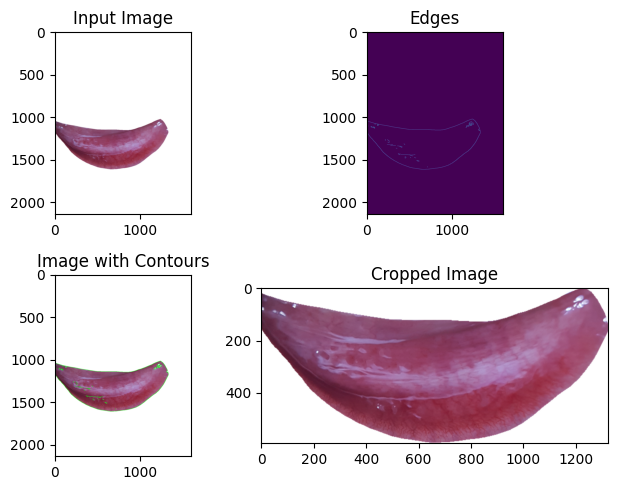

In [29]:
# create figure
fig = plt.figure(figsize=(7, 5))

# setting values to rows and column variables 
rows = 2
columns = 2

# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1)

# showing image 
plt.tight_layout()
plt.imshow(img) 
# plt.axis('off') 
plt.title(f"Input Image")

# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2)

# showing image
plt.tight_layout() 
plt.imshow(edges) 
# plt.axis('off') 
plt.title(f"Edges")

# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 3)

# showing image
plt.tight_layout() 
plt.imshow(img_copy) 
# plt.axis('off') 
plt.title(f"Image with Contours")

# Adds a subplot at the 4th position 
fig.add_subplot(rows, columns, 4)

# showing image
plt.tight_layout() 
plt.imshow(cropped_img) 
# plt.axis('off') 
plt.title(f"Cropped Image")

In [30]:
cropped_img_folder = []
for image in images:

    img = mask(image)
    edges = canny_edge_detection(img)
    img_copy,contours = get_contours(img,edges)
    cropped_img = crop(img,contours) 
    
    cropped_img_folder.append(cropped_img)

In [31]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

In [32]:
df = pd.read_excel("../India_95/India.xlsx",0)

In [33]:
from torchvision.models import resnet18, ResNet18_Weights

resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
# or any of these variants
# from torchvision.models import resnet34, ResNet34_Weights
# from torchvision.models import resnet50, ResNet50_Weights
# from torchvision.models import resnet101, ResNet101_Weights
# from torchvision.models import resnet152, ResNet152_Weights

modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

resnet.eval()

def preprocess_image(img):

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return preprocess(img).unsqueeze(0)

In [34]:
All_Data = []
errors = []

for i in range(len(cropped_img_folder)):

    number = int(images[i].split("/")[-2])

    label = df.loc[df['Number'] == int(number)]['Hgb'].tolist()[0]

    try:
        input_batch = preprocess_image(Image.fromarray(np.uint8(cropped_img_folder[i])))

        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            resnet.to('cuda')

        with torch.no_grad():
            output = resnet(input_batch)

        # data = [number,label]
        output = output.cpu()
        data = output.squeeze().numpy()
        data = data.flatten().tolist()

        data.insert(0,number)
        data.append(label)

        All_Data.append(data)

    except Exception as e:
        error = [number,e]
        errors.append(error)

In [35]:
len(All_Data)

95

In [36]:
len(errors)

0

In [37]:
headers = ['number']
for i in range(512):
    col = 'data_' + str(i)
    headers.append(col)
headers.append('label')
df_save = pd.DataFrame(All_Data, columns=headers)
# df_save.to_csv('../India_95/Data_new.csv', index=False)

In [38]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [39]:
data = df_save

In [40]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.3)

In [41]:
# Separate features and target variable in train data
X_train = train_data.drop(columns=['number','label'])
y_train = train_data['label']

# Separate features and target variable in test data
X_test = test_data.drop(columns=['number','label'])
y_test = test_data['label']

In [42]:
algorithms = {
    'Linear Regression': LinearRegression(),
    'SVM Regression': SVR(kernel='poly'),  # Adjust kernel as needed
    'RandomForest': RandomForestRegressor(),
    'Gradient Boost': GradientBoostingRegressor(),
    'knn': KNeighborsRegressor(),
    'LGBM': LGBMRegressor(),
    'CatBoost': CatBoostRegressor(),
    'Kernel Ridge Regressor': KernelRidge(),
    'Elastic Net': ElasticNet(),
    'Bayesian Ridge': BayesianRidge(),
    'XG Boost': XGBRegressor()
}

In [43]:
# Metric tables
metric_table_train = pd.DataFrame()
metric_table_test = pd.DataFrame()

In [44]:
# Run the algorithms ... create metrics and plots
for algorithm_name, algorithm in algorithms.items():

    # Train model
    algorithm.fit(X_train, y_train)

    # Train predictions
    y_train_pred = algorithm.predict(X_train)

    # Test predictions
    y_test_pred = algorithm.predict(X_test)

    # Train metrics
    r2_train = algorithm.score(X_train, y_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    # Test metrics
    r2_test = algorithm.score(X_test, y_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Additional metrics using statsmodels for all algorithms
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred

    durbin_watson_stat_train = sm.stats.durbin_watson(residuals_train)
    jb_stat_train, jb_p_value_train, _, _ = sm.stats.jarque_bera(residuals_train)

    durbin_watson_stat_test = sm.stats.durbin_watson(residuals_test)
    jb_stat_test, jb_p_value_test, _, _ = sm.stats.jarque_bera(residuals_test)

    # Update metric tables
    metric_table_train.at[algorithm_name, 'MAE'] = mae_train
    metric_table_train.at[algorithm_name, 'R-squared'] = r2_train
    metric_table_train.at[algorithm_name, 'MSE'] = mse_train
    metric_table_train.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_train
    metric_table_train.at[algorithm_name, 'Jarque-Bera'] = jb_stat_train
    metric_table_train.at[algorithm_name, 'JB P-value'] = jb_p_value_train

    metric_table_test.at[algorithm_name, 'MAE'] = mae_test
    metric_table_test.at[algorithm_name, 'R-squared'] = r2_test
    metric_table_test.at[algorithm_name, 'MSE'] = mse_test
    metric_table_test.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_test
    metric_table_test.at[algorithm_name, 'Jarque-Bera'] = jb_stat_test
    metric_table_test.at[algorithm_name, 'JB P-value'] = jb_p_value_test


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11600
[LightGBM] [Info] Number of data points in the train set: 66, number of used features: 512
[LightGBM] [Info] Start training from score 11.189394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [45]:
# Display metrics in tables
print("Metrics - Train Data:\n")
print(metric_table_train.to_string())
print("-------------------------------------------------")

print("Metrics - Test Data:\n")
print(metric_table_test.to_string())

Metrics - Train Data:

                                 MAE  R-squared           MSE  Durbin-Watson  Jarque-Bera    JB P-value
Linear Regression       4.615836e-15   1.000000  3.825975e-29       1.959700     2.440035  2.952250e-01
SVM Regression          6.781337e-01   0.700838  1.203277e+00       2.283098     7.087297  2.890767e-02
RandomForest            5.999091e-01   0.868391  5.293512e-01       2.122959     2.014984  3.651336e-01
Gradient Boost          5.312770e-03   0.999990  3.828238e-05       2.408695     2.246909  3.251547e-01
knn                     1.380606e+00   0.259313  2.979164e+00       2.310946     0.197729  9.058653e-01
LGBM                    2.859071e-01   0.963870  1.453192e-01       2.116408     8.361729  1.528528e-02
CatBoost                1.000563e-03   1.000000  1.380332e-06       2.491362     3.063282  2.161806e-01
Kernel Ridge Regressor  1.242481e-01   0.993685  2.539850e-02       2.178934     1.002369  6.058127e-01
Elastic Net             1.641452e+00   0.

In [46]:
import pycaret

In [47]:
from pycaret.regression import *
s = setup(data, target='label', ignore_features=['number'], 
          #log_experiment=True, experiment_name="resnet_2", log_data=True, 
          pca=True, pca_method="linear", 
          remove_multicollinearity=True, multicollinearity_threshold=0.5, 
          #feature_selection=True, feature_selection_method="sequential", n_features_to_select='auto', 
          normalize=True, 
          session_id=123)

,Description,Value
0,Session id,123
1,Target,label
2,Target type,Regression
3,Original data shape,"(95, 514)"
4,Transformed data shape,"(95, 67)"
5,Transformed train set shape,"(66, 67)"
6,Transformed test set shape,"(29, 67)"
7,Ignore features,1
8,Numeric features,512
9,Preprocess,True


In [48]:
best_r = compare_models(sort="RMSE")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dummy,Dummy Regressor,1.7746,4.5818,2.0761,-0.1992,0.1700,0.1622,0.0300
lasso,Lasso Regression,1.7811,4.6050,2.0785,-0.2018,0.1702,0.1624,0.1400
llar,Lasso Least Angle Regression,1.7811,4.6050,2.0785,-0.2018,0.1702,0.1624,0.0290
rf,Random Forest Regressor,1.7751,4.8113,2.1172,-0.2578,0.1731,0.1633,0.0440
catboost,CatBoost Regressor,1.8049,4.8709,2.1481,-0.3234,0.1756,0.1654,1.1300
et,Extra Trees Regressor,1.8603,4.8955,2.1524,-0.3219,0.1754,0.1699,0.0410
en,Elastic Net,1.8399,4.9760,2.1712,-0.3318,0.1780,0.1687,0.0290
br,Bayesian Ridge,1.8671,5.2234,2.1969,-0.3228,0.1804,0.1726,0.0310
knn,K Neighbors Regressor,1.8485,5.2507,2.2390,-0.5926,0.1837,0.1764,0.0300
ada,AdaBoost Regressor,1.8341,5.3155,2.2401,-0.5118,0.1829,0.1692,0.0510
